In this file, we recreate the experiment done by Lorenz et Coecke, but rewrite them using Lambeq. 
Then, using DisCoPy methods, we extract the trained circuit parameters to see to what extent they are storing semantics. 

In [1]:
BATCH_SIZE = 30
EPOCHS = 30
LEARNING_RATE = 3e-2
SEED = 0

In [2]:
# Import all kinds of lambeq stuff 
from lambeq.backend.grammar import (Box, Cap, Cup, Diagram, Diagrammable,
                                    Functor, grammar, Id, Spider, Swap,
                                    Ty, Word)
from lambeq.backend.drawing import draw
import matplotlib.pyplot as plt
import matplotlib
from lambeq import AtomicType

# optimising the diagram to make the resulting quanutm circuit less complex
from lambeq import RemoveSwapsRewriter, RemoveCupsRewriter
from lambeq import Rewriter 

# creating the quantum circuit
from lambeq import IQPAnsatz
from pytket.extensions.qiskit import tk_to_qiskit

import numpy as np

# amplitude Encoding
from qiskit import QuantumCircuit

In [3]:
import numpy as np

BATCH_SIZE = 10
EPOCHS = 300
SEED = 2

In [4]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../datasets/mc_train_data.txt')
test_labels, test_data = read_data('../datasets/mc_test_data.txt')
val_labels, val_data = read_data('../datasets/mc_dev_data.txt')


# here, we can choose between either the original dataset by Coecke et al. or the new one for Gijs' data

gijs = True

if not gijs: 
    # new way, maybe the things after the words confused lambeq in creating the diagrams 
    with open('../datasets/newTestSentences.txt', 'r') as file: 
        test_data = file.readlines()
    with open('../datasets/newTrainSentences.txt', 'r') as file: 
        train_data = file.readlines()
    with open('../datasets/newValSentences.txt', 'r') as file: 
        val_data = file.readlines()

    test_data = [sentence.strip() for sentence in test_data]
    train_data = [sentence.strip() for sentence in train_data]
    val_data = [sentence.strip() for sentence in val_data]


if gijs:
    # new way, maybe the things after the words confused lambeq in creating the diagrams 
    with open('../datasets/testGijs.txt', 'r') as file: 
        test_data = file.readlines()
    with open('../datasets/trainGijs.txt', 'r') as file: 
        train_data = file.readlines()
    with open('../datasets/valGijs.txt', 'r') as file: 
        val_data = file.readlines()

    test_data = [sentence.strip() for sentence in test_data]
    train_data = [sentence.strip() for sentence in train_data]
    val_data = [sentence.strip() for sentence in val_data]


In [5]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


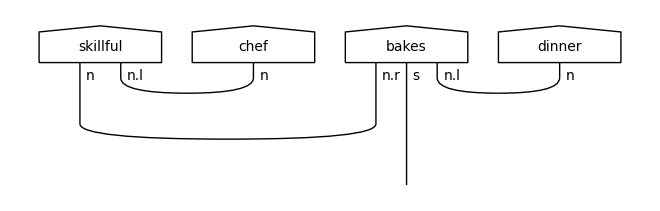

In [6]:
raw_train_diagrams[1].draw()

In [7]:
# normalising 

from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_val_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]



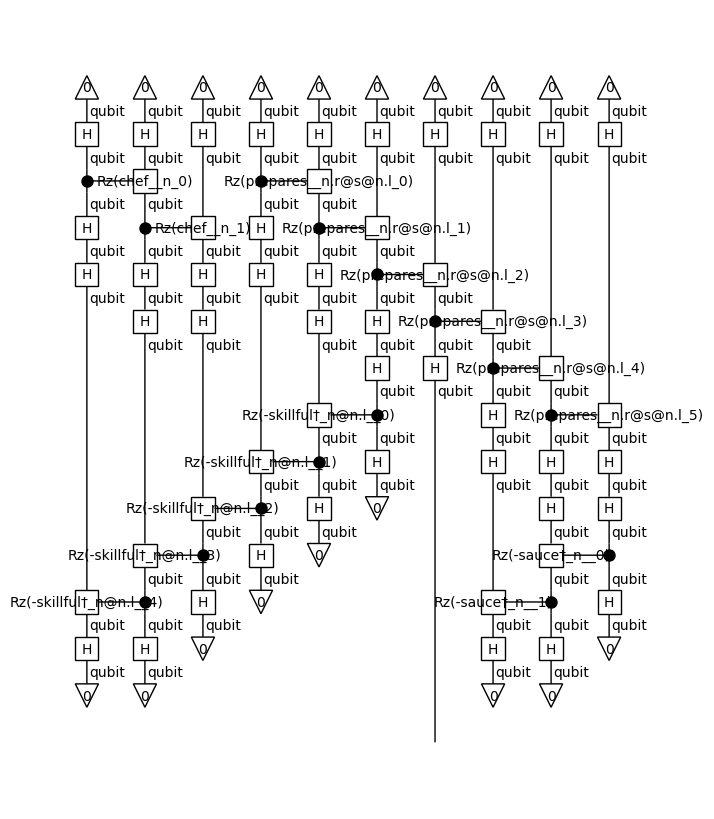

In [14]:
# create quantum circuits

from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 2, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
val_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(6, 8))

In [11]:
from lambeq import PennyLaneModel

all_circuits = train_circuits + val_circuits + test_circuits

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit'}  # this is the default PennyLane simulator
modelPennylane = PennyLaneModel.from_diagrams(all_circuits,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
modelPennylane.initialise_weights()



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)
                          
val_dataset = Dataset(val_circuits, val_labels)

In [13]:
def accPL(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

In [14]:
from lambeq import PytorchTrainer
import torch

trainerPennylane = PytorchTrainer(
    model=modelPennylane,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': accPL},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

In [15]:
# trainer.fit(train_dataset, val_dataset)#, early_stopping_interval=10)

trainerPennylane.fit(train_dataset, val_dataset)

Epoch 1:    train/loss: 0.0723   valid/loss: 0.1415   train/acc: 0.6286   valid/acc: 0.7667
Epoch 2:    train/loss: 0.0211   valid/loss: 0.0550   train/acc: 0.9143   valid/acc: 1.0000
Epoch 3:    train/loss: 0.0046   valid/loss: 0.0265   train/acc: 0.9857   valid/acc: 1.0000
Epoch 4:    train/loss: 0.0038   valid/loss: 0.0153   train/acc: 1.0000   valid/acc: 1.0000
Epoch 5:    train/loss: 0.0103   valid/loss: 0.0092   train/acc: 1.0000   valid/acc: 1.0000
Epoch 6:    train/loss: 0.0040   valid/loss: 0.0055   train/acc: 1.0000   valid/acc: 1.0000
Epoch 7:    train/loss: 0.0017   valid/loss: 0.0026   train/acc: 1.0000   valid/acc: 1.0000
Epoch 8:    train/loss: 0.0004   valid/loss: 0.0013   train/acc: 1.0000   valid/acc: 1.0000
Epoch 9:    train/loss: 0.0002   valid/loss: 0.0013   train/acc: 1.0000   valid/acc: 1.0000
Epoch 10:   train/loss: 0.0010   valid/loss: 0.0017   train/acc: 1.0000   valid/acc: 1.0000
Epoch 11:   train/loss: 0.0001   valid/loss: 0.0018   train/acc: 1.0000   valid/

In [16]:
# Do the same thing, but now using the NUMPY model! 

from lambeq import NumpyModel

modelNumpy = NumpyModel.from_diagrams(all_circuits, use_jit=False)


from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

accNP = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": accNP}


# NUMPY model uses QuantumTrainer class 

from lambeq import QuantumTrainer, SPSAOptimizer

trainerNumpy = QuantumTrainer(
    modelNumpy,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)




In [17]:
# train the numpy model 

trainerNumpy.fit(train_dataset, val_dataset)

Epoch 1:    train/loss: 0.6541   valid/loss: 0.7426   train/acc: 0.5857   valid/acc: 0.6333
Epoch 2:    train/loss: 0.5297   valid/loss: 0.7104   train/acc: 0.6857   valid/acc: 0.7000
Epoch 3:    train/loss: 0.7368   valid/loss: 0.5235   train/acc: 0.6857   valid/acc: 0.7667
Epoch 4:    train/loss: 0.3694   valid/loss: 0.4834   train/acc: 0.7571   valid/acc: 0.8000
Epoch 5:    train/loss: 0.3028   valid/loss: 0.5072   train/acc: 0.7571   valid/acc: 0.7667
Epoch 6:    train/loss: 0.2518   valid/loss: 0.4872   train/acc: 0.7714   valid/acc: 0.7333
Epoch 7:    train/loss: 0.3023   valid/loss: 0.4602   train/acc: 0.8429   valid/acc: 0.8333
Epoch 8:    train/loss: 0.3823   valid/loss: 0.3441   train/acc: 0.8429   valid/acc: 0.9000
Epoch 9:    train/loss: 0.3041   valid/loss: 0.3380   train/acc: 0.8714   valid/acc: 0.8333
Epoch 10:   train/loss: 0.2057   valid/loss: 0.2358   train/acc: 0.8857   valid/acc: 0.9333
Epoch 11:   train/loss: 0.1345   valid/loss: 0.2514   train/acc: 0.8714   valid/

In [18]:
'''
Same thing, but for Tket model 
'''

from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

modelTK = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bceTK = BinaryCrossEntropyLoss()

accTK = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metricsTK = {"acc": accTK}

from lambeq import QuantumTrainer, SPSAOptimizer

trainerTK = QuantumTrainer(
    modelTK,
    loss_function=bceTK,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metricsTK,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)


trainerTK.fit(train_dataset, val_dataset)#, early_stopping_interval=10)

Epoch 1:    train/loss: 1.1153   valid/loss: 1.6434   train/acc: 0.5000   valid/acc: 0.3500
Epoch 2:    train/loss: 1.3886   valid/loss: 1.0988   train/acc: 0.4286   valid/acc: 0.5000
Epoch 3:    train/loss: 1.1676   valid/loss: 0.6341   train/acc: 0.4000   valid/acc: 0.6667
Epoch 4:    train/loss: 1.6282   valid/loss: 2.1260   train/acc: 0.4857   valid/acc: 0.4667
Epoch 5:    train/loss: 0.6986   valid/loss: 0.7759   train/acc: 0.5643   valid/acc: 0.6000
Epoch 6:    train/loss: 2.5610   valid/loss: 1.1268   train/acc: 0.4357   valid/acc: 0.5333
Epoch 7:    train/loss: 0.3923   valid/loss: 0.9931   train/acc: 0.5286   valid/acc: 0.4000
Epoch 8:    train/loss: 0.8034   valid/loss: 1.4584   train/acc: 0.5714   valid/acc: 0.5667
Epoch 9:    train/loss: 0.5893   valid/loss: 1.5828   train/acc: 0.5143   valid/acc: 0.5667
Epoch 10:   train/loss: 0.5197   valid/loss: 0.7607   train/acc: 0.5857   valid/acc: 0.5333
Epoch 11:   train/loss: 0.9123   valid/loss: 0.8274   train/acc: 0.7286   valid/

In [39]:
'''
Before we look at the results of the training, let us understand what exactly these circuits are that we trained above. 

We start by extracting the parameters for the symbols learned by Coecke et al. 


'''

# The symbols are the names of the respective parameters for the respective words
smbls = modelTK.symbols

# And the weights are their respective values 
weights = modelTK.weights

print('symbols: ', smbls)
print('weights: ', weights)

# now, we are only interested in the noun weights 

newSmbls = []
newWeights = []

verbSmbls = []
verbWeights = []

adjSmbls = []
adjWeights = []

for i in range(len(weights)): 
    if '__n_' in str(smbls[i]):# or '_N†_n__' in str(smbls[i]):
        newSmbls.append(smbls[i])
        newWeights.append(weights[i].item())
    elif 'TV' in str(smbls[i]): 
        verbSmbls.append(smbls[i])
        verbWeights.append(weights[i].item())
    elif 'ADJ' in str(smbls[i]): 
        adjSmbls.append(smbls[i])
        adjWeights.append(weights[i].item())


# create a simple dictionary for parameters and weights 
parameterDict = {}
for i in range(len(smbls)):
    parameterDict[str(smbls[i])] = weights[i].item()

print(parameterDict)

import pickle

with open('../datasets/weightsDictTKGijs.pkl', 'wb') as fp:
    pickle.dump(parameterDict, fp)


print(newSmbls)
print(newWeights)


symbols:  [application__n_0, application__n_1, application__n_2, application†_n__0, application†_n__1, application†_n__2, bakes__n.r@s@n.l_0, bakes__n.r@s@n.l_1, chef__n_0, chef__n_1, chef__n_2, chef†_n__0, chef†_n__1, chef†_n__2, cooks__n.r@s@n.l_0, cooks__n.r@s@n.l_1, dinner__n_0, dinner__n_1, dinner__n_2, dinner†_n__0, dinner†_n__1, dinner†_n__2, meal__n_0, meal__n_1, meal__n_2, meal†_n__0, meal†_n__1, meal†_n__2, person__n_0, person__n_1, person__n_2, person†_n__0, person†_n__1, person†_n__2, prepares__n.r@s@n.l_0, prepares__n.r@s@n.l_1, program__n_0, program__n_1, program__n_2, programmer__n_0, programmer__n_1, programmer__n_2, programmer†_n__0, programmer†_n__1, programmer†_n__2, program†_n__0, program†_n__1, program†_n__2, reads__n.r@s@n.l_0, reads__n.r@s@n.l_1, runs__n.r@s@n.l_0, runs__n.r@s@n.l_1, sauce__n_0, sauce__n_1, sauce__n_2, sauce†_n__0, sauce†_n__1, sauce†_n__2, skillful†_n@n.l__0, software__n_0, software__n_1, software__n_2, software†_n__0, software†_n__1, software†_

Symbol =  application__n_0
Statevector =  Statevector([0.56195596-0.63231681j, 0.32413556-0.42345849j],
            dims=(2,))
Symbol =  chef__n_0
Statevector =  Statevector([ 0.78544459+0.40877584j, -0.2892802 -0.36372526j],
            dims=(2,))
Symbol =  dinner__n_0
Statevector =  Statevector([ 0.73166217+0.09394674j, -0.00821562-0.67511257j],
            dims=(2,))
Symbol =  meal__n_0
Statevector =  Statevector([0.51469315-0.65630074j, 0.01021186+0.55159407j],
            dims=(2,))
Symbol =  person__n_0
Statevector =  Statevector([-0.67776115+0.30985038j,  0.3203065 -0.5848387j ],
            dims=(2,))
Symbol =  program__n_0
Statevector =  Statevector([0.72936227+0.3144721j , 0.23106191-0.56191491j],
            dims=(2,))
Symbol =  programmer__n_0
Statevector =  Statevector([ 0.81970788+0.56580734j, -0.08712797+0.01870199j],
            dims=(2,))
Symbol =  sauce__n_0
Statevector =  Statevector([ 0.58565326+0.04417454j, -0.00604257-0.80933451j],
            dims=(2,))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Symbol =  software__n_0
Statevector =  Statevector([0.89745556+0.08196745j, 0.01600337+0.43312672j],
            dims=(2,))


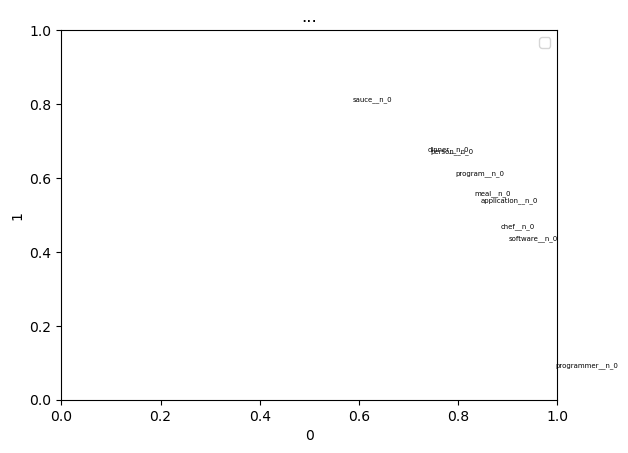

In [40]:
'''
We want to see to what exact quantum states the respective nouns are mapped. We define a qiskit circuit consisting of a Rx, Rz, and Rx gate and we look at the quantum 
states that the respective nouns are mapped to. 
'''
# import matplotlib
from qiskit import QuantumCircuit, Aer, execute

def getProbDist(listOfParams): 
    '''
    Given a list of parameters, this function creates a circuit and returns the state and the probability distribution of said state
    '''

    # Create a quantum circuit with one qubit
    qc = QuantumCircuit(1, 1)

    # Initialize the qubit to the |0⟩ state
    initial_state = [1, 0]  # Coefficients for the |0⟩ state
    qc.initialize(initial_state, 0)

    # Apply Rx and Rz gates
    qc.rx(listOfParams[0], 0)
    qc.rz(listOfParams[1], 0) 
    qc.rx(listOfParams[2], 0)


    # statevectors simulator for UNMEASURED CIRCUIT
    backend = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend=backend, shots = 1, memory = True)
    stateVector = job.result().get_statevector(qc)


    # Measure the qubit
    qc.measure(0, 0)  # Measure qubit 0 and store the result in classical bit 0

    # Draw the circuit (optional)
    # print("Quantum Circuit:")
    # qc.draw(output='mpl', filename = 'testtesttest.png')

    # Use the Aer simulator to execute the circuit
    simulator = Aer.get_backend('qasm_simulator')
    shots = 100000  # Number of times to run the circuit
    job = execute(qc, simulator, shots=shots)  # Execute the circuit
    result = job.result()
    counts = result.get_counts(qc)

    

    # Calculate the probability distribution
    prob_dist = {state: counts[state] / shots for state in counts}

    return prob_dist, stateVector


NounsAndVecs = {}
nounStateList = []

# for plotting the Bloch spheres
from qiskit.visualization import plot_bloch_multivector

for i in range(0, len(newWeights), 3): 

    params = newWeights[i:i+3]

    # print(newSmbls[i:i+3])

    # print(params)

    probDist, nounState = getProbDist(params)

    nounStateList.append(nounState)

    # plot bloch sphere 
    print('Symbol = ', str(newSmbls[i]))
    print('Statevector = ', str(nounState))
    plot_bloch_multivector(nounState, title=str(newSmbls[i]), filename = 'blochMultivector' + str(i) + '.png')

    NounsAndVecs[str(newSmbls[i])] = probDist

    # plot in 2-dim cartesian system
    plt.text(np.sqrt(probDist['0']), np.sqrt(probDist['1']), str(newSmbls[i]), fontsize = 5)


plt.title('...')
plt.ylabel('1')
plt.xlabel('0')
plt.legend()
plt.show()
# print(NounsAndVecs)



In [21]:
'''
We see that there is *no* system whatsoever. 
This might be due to the poor training as we can see in the plots below. 

I could do an animation here. And with the loss function being minimized we see the vectors of the different words changing (hopefully in some intuitive way)

Later, we can use this 'proof' kind of idea to amplitude these things prior to the execution of the algorithm. 


NEXT STEP: INVESTIGATE THE VERBS AND RECONSTRUCT THE STATES THEY ARE MAPPED TO 

'''

"\nWe see that there is *no* system whatsoever. \nThis might be due to the poor training as we can see in the plots below. \n\nI could do an animation here. And with the loss function being minimized we see the vectors of the different words changing (hopefully in some intuitive way)\n\nLater, we can use this 'proof' kind of idea to amplitude these things prior to the execution of the algorithm. \n\n\nNEXT STEP: INVESTIGATE THE VERBS AND RECONSTRUCT THE STATES THEY ARE MAPPED TO \n\n"

In [22]:
def VerbCircuit(paramList, draw = False): 
    '''
    returns probability distribution over possible states
    '''

    # create quantum circuit with three qubits 
    qc = QuantumCircuit(3)

    # Initialize the qubit to the |0⟩ state
    initial_state = [1, 0]  # Coefficients for the |0⟩ state
    qc.initialize(initial_state, 0)
    qc.initialize(initial_state, 1)
    qc.initialize(initial_state, 2)

    qc.h(range(3))

    # add CNOT gates 
    qc.crz(paramList[0], 2, 1)
    qc.crz(paramList[1], 1, 0)

    qc.h(range(3))

    if draw: 
        print(qc)
        qc.draw(output='mpl', filename='verbCircuit.png')
    
    simulator = Aer.get_backend('statevector_simulator')

    # use this if you want the *complex* statevector!!
    # 
    # job = execute(qc, simulator)
    # result = job.result()
    # statevector = result.get_statevector()
    shots = 100000  # Number of times to run the circuit
    job = execute(qc, simulator, shots=shots)  # Execute the circuit
    result = job.result()
    counts = result.get_counts(qc)

    # Calculate the probability distribution
    prob_dist = {state: counts[state] / shots for state in counts}

    return prob_dist

print(VerbCircuit([1,2], draw= True))



     ┌─────────────────┐┌───┐         ┌───────┐┌───┐
q_0: ┤ Initialize(1,0) ├┤ H ├─────────┤ Rz(2) ├┤ H ├
     ├─────────────────┤├───┤┌───────┐└───┬───┘├───┤
q_1: ┤ Initialize(1,0) ├┤ H ├┤ Rz(1) ├────■────┤ H ├
     ├─────────────────┤├───┤└───┬───┘  ┌───┐  └───┘
q_2: ┤ Initialize(1,0) ├┤ H ├────■──────┤ H ├───────
     └─────────────────┘└───┘           └───┘       


/home/bob/anaconda3/envs/code/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


{'000': 5.25780934030603e-06, '001': 1.66183287836071e-06, '010': 8.0643771242442e-07, '011': 1.66183287836071e-06, '100': 5.257933299646e-08, '101': 1.0835066732322e-07, '110': 3.4280652290523e-07, '111': 1.0835066732322e-07}


In [23]:
'''
Now, the same thing for adjectives
'''

def AdjectivesCircuit(paramList, draw = False): 
    '''
    returns probability distribution over possible states
    '''

    # create quantum circuit with three qubits 
    qc = QuantumCircuit(2)

    # Initialize the qubit to the |0⟩ state
    initial_state = [1, 0]  # Coefficients for the |0⟩ state
    qc.initialize(initial_state, 0)
    qc.initialize(initial_state, 1)

    qc.h(range(2))

    # add CNOT gates 
    qc.crz(paramList[0], 1, 0)

    qc.h(range(2))

    if draw: 
        print(qc)
        qc.draw(output='mpl', filename='adjCircuit.png')
    
    simulator = Aer.get_backend('statevector_simulator')

    # use this if you want the *complex* statevector!!
    # 
    # job = execute(qc, simulator)
    # result = job.result()
    # statevector = result.get_statevector()
    shots = 100000  # Number of times to run the circuit
    job = execute(qc, simulator, shots=shots)  # Execute the circuit
    result = job.result()
    counts = result.get_counts(qc)

    # Calculate the probability distribution
    prob_dist = {state: counts[state] / shots for state in counts}

    return prob_dist

print(AdjectivesCircuit([3.14], draw= True))



     ┌─────────────────┐┌───┐┌──────────┐┌───┐
q_0: ┤ Initialize(1,0) ├┤ H ├┤ Rz(3.14) ├┤ H ├
     ├─────────────────┤├───┤└────┬─────┘├───┤
q_1: ┤ Initialize(1,0) ├┤ H ├─────■──────┤ H ├
     └─────────────────┘└───┘            └───┘
{'00': 2.50398321889424e-06, '01': 2.49999841465942e-06, '10': 2.49601995178691e-06, '11': 2.49999841465942e-06}


Final test accuracy: 0.0


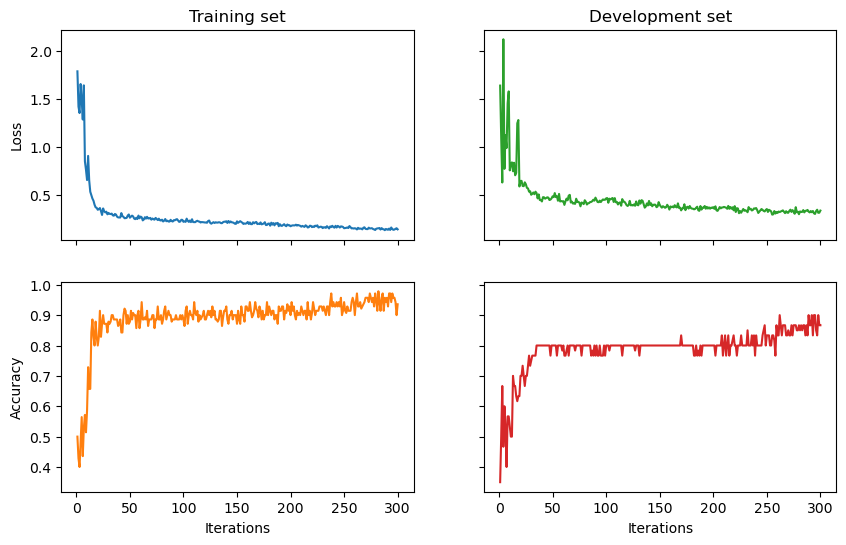

In [43]:
import matplotlib.pyplot as plt

trainer = trainerTK
model = modelTK
acc = accTK
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circuits)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))

In [25]:
'''
Now, for the density matrix part. 
We write a qiskit circuit and we predict, given the weights, the density matrices with the nouns missing
''' 
from qiskit import QuantumCircuit

a = modelNumpy.get_diagram_output(test_circuits)
print(len(a))

print(a)

# print(len(test_circuits))
# print(len(pred))

30
[[9.92149399e-01 7.85060114e-03]
 [9.98551806e-01 1.44819423e-03]
 [1.50975648e-02 9.84902435e-01]
 [9.87618831e-01 1.23811690e-02]
 [9.96421354e-01 3.57864612e-03]
 [1.72885575e-02 9.82711442e-01]
 [1.25862201e-01 8.74137799e-01]
 [9.92871090e-01 7.12891005e-03]
 [9.82679228e-01 1.73207716e-02]
 [9.98569814e-01 1.43018606e-03]
 [9.96419949e-01 3.58005082e-03]
 [9.70291162e-04 9.99029709e-01]
 [9.89186932e-01 1.08130684e-02]
 [9.97655585e-01 2.34441471e-03]
 [9.86325107e-01 1.36748932e-02]
 [5.01758802e-03 9.94982412e-01]
 [2.05592743e-02 9.79440726e-01]
 [1.11961378e-02 9.88803862e-01]
 [1.03377298e-02 9.89662270e-01]
 [1.31601047e-02 9.86839895e-01]
 [1.86015446e-02 9.81398455e-01]
 [6.43840135e-01 3.56159865e-01]
 [9.89124460e-01 1.08755404e-02]
 [9.95240105e-01 4.75989530e-03]
 [1.92470343e-01 8.07529657e-01]
 [9.97184433e-01 2.81556742e-03]
 [3.51448926e-02 9.64855107e-01]
 [9.90747443e-01 9.25255724e-03]
 [8.78071843e-03 9.91219282e-01]
 [9.95932360e-01 4.06764017e-03]]
